In [1]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import statsmodels.api as sm  
from statsmodels.tsa.stattools import acf, pacf
from pmdarima import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
import seaborn as sns
from statsmodels.tsa.seasonal import STL
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score
from statsmodels.stats.diagnostic import acorr_ljungbox


# Analisi esplorativa 

In [2]:
data = pd.read_csv('Time_series/sp500_stocks.csv')
data.head()
print(f"Lunghezza data: {len(data)}")

Lunghezza data: 1872669


I valori degli attributi dei campioni prima del 2019 hanno una media e una varianza molto bassa e simile tra loro, eccezion fatta per il volume. quindi anzichè addestrare il modello dal 2010 al 2024, esso viene addestrato tenendo conto dei campioni dal 2019 al 2024

In [3]:
# Filtrare i dati per il simbolo 'NVDA'
nvda_data = data[data['Symbol'] == 'NVDA']
# Convertire la colonna 'Date' in formato datetime
nvda_data['Date'] = pd.to_datetime(nvda_data['Date'])

C:\Users\gians_ji5genm\AppData\Local\Temp\ipykernel_18852\2952638250.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nvda_data['Date'] = pd.to_datetime(nvda_data['Date'])


In [4]:
filtered_data = nvda_data[nvda_data['Date'] <= '2018-12-31']
filtered_data[["Close","Open","High","Low","Volume", "Adj Close"]].describe()

,Close,Open,High,Low,Volume,Adj Close
count,2264.000000,2264.000000,2264.000000,2264.000000,2.264000e+03,2264.000000
mean,1.487953,1.488736,1.510190,1.464365,5.294024e+08,1.456810
std,1.906598,1.908764,1.935563,1.876722,3.580490e+08,1.895319
min,0.222000,0.218000,0.226250,0.216250,4.564400e+07,0.203607
25%,0.365250,0.364938,0.370000,0.359500,2.998890e+08,0.336802
50%,0.478750,0.479625,0.485625,0.473375,4.352900e+08,0.453203
75%,1.650625,1.647250,1.665250,1.634063,6.518430e+08,1.624127
max,7.234000,7.233000,7.319000,7.139500,3.692928e+09,7.169096


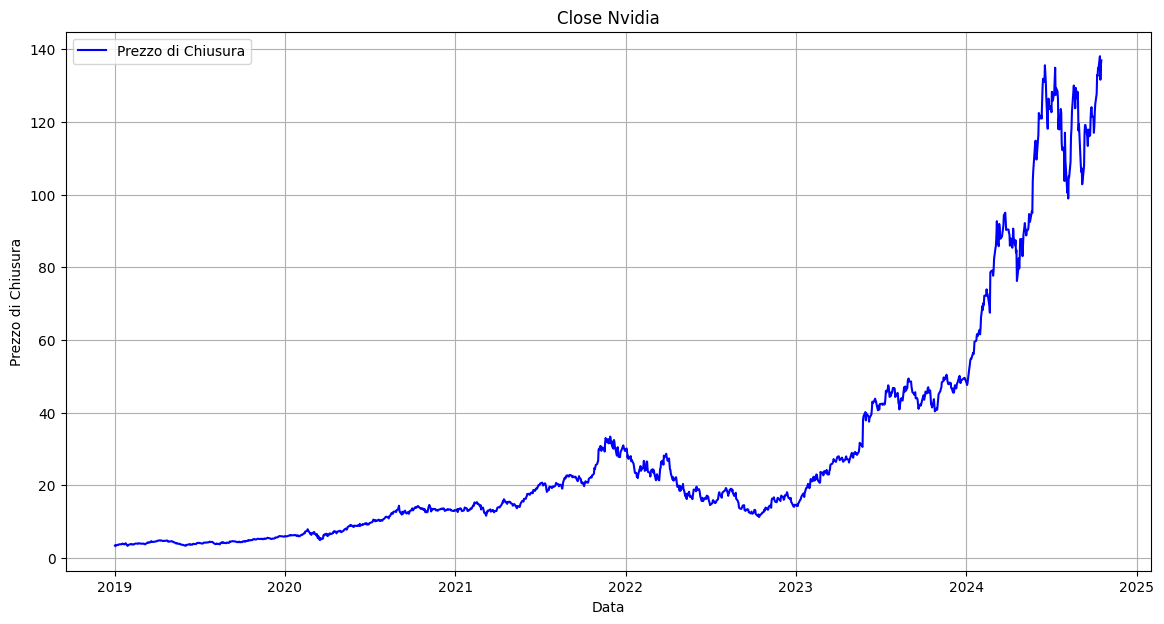

In [5]:

# Filtrare i dati per includere solo quelli dal 2019 in poi
nvda_data = nvda_data[nvda_data['Date'] >= '2019-01-01']

# Ordinare i dati per data
nvda_data = nvda_data.sort_values(by='Date')

# Tracciare il grafico dei prezzi di chiusura
plt.figure(figsize=(14, 7))
plt.plot(nvda_data['Date'], nvda_data['Close'], label='Prezzo di Chiusura', color='blue')
plt.title('Close Nvidia')
plt.xlabel('Data')
plt.ylabel('Prezzo di Chiusura')
plt.grid(True)
plt.legend()
plt.show()


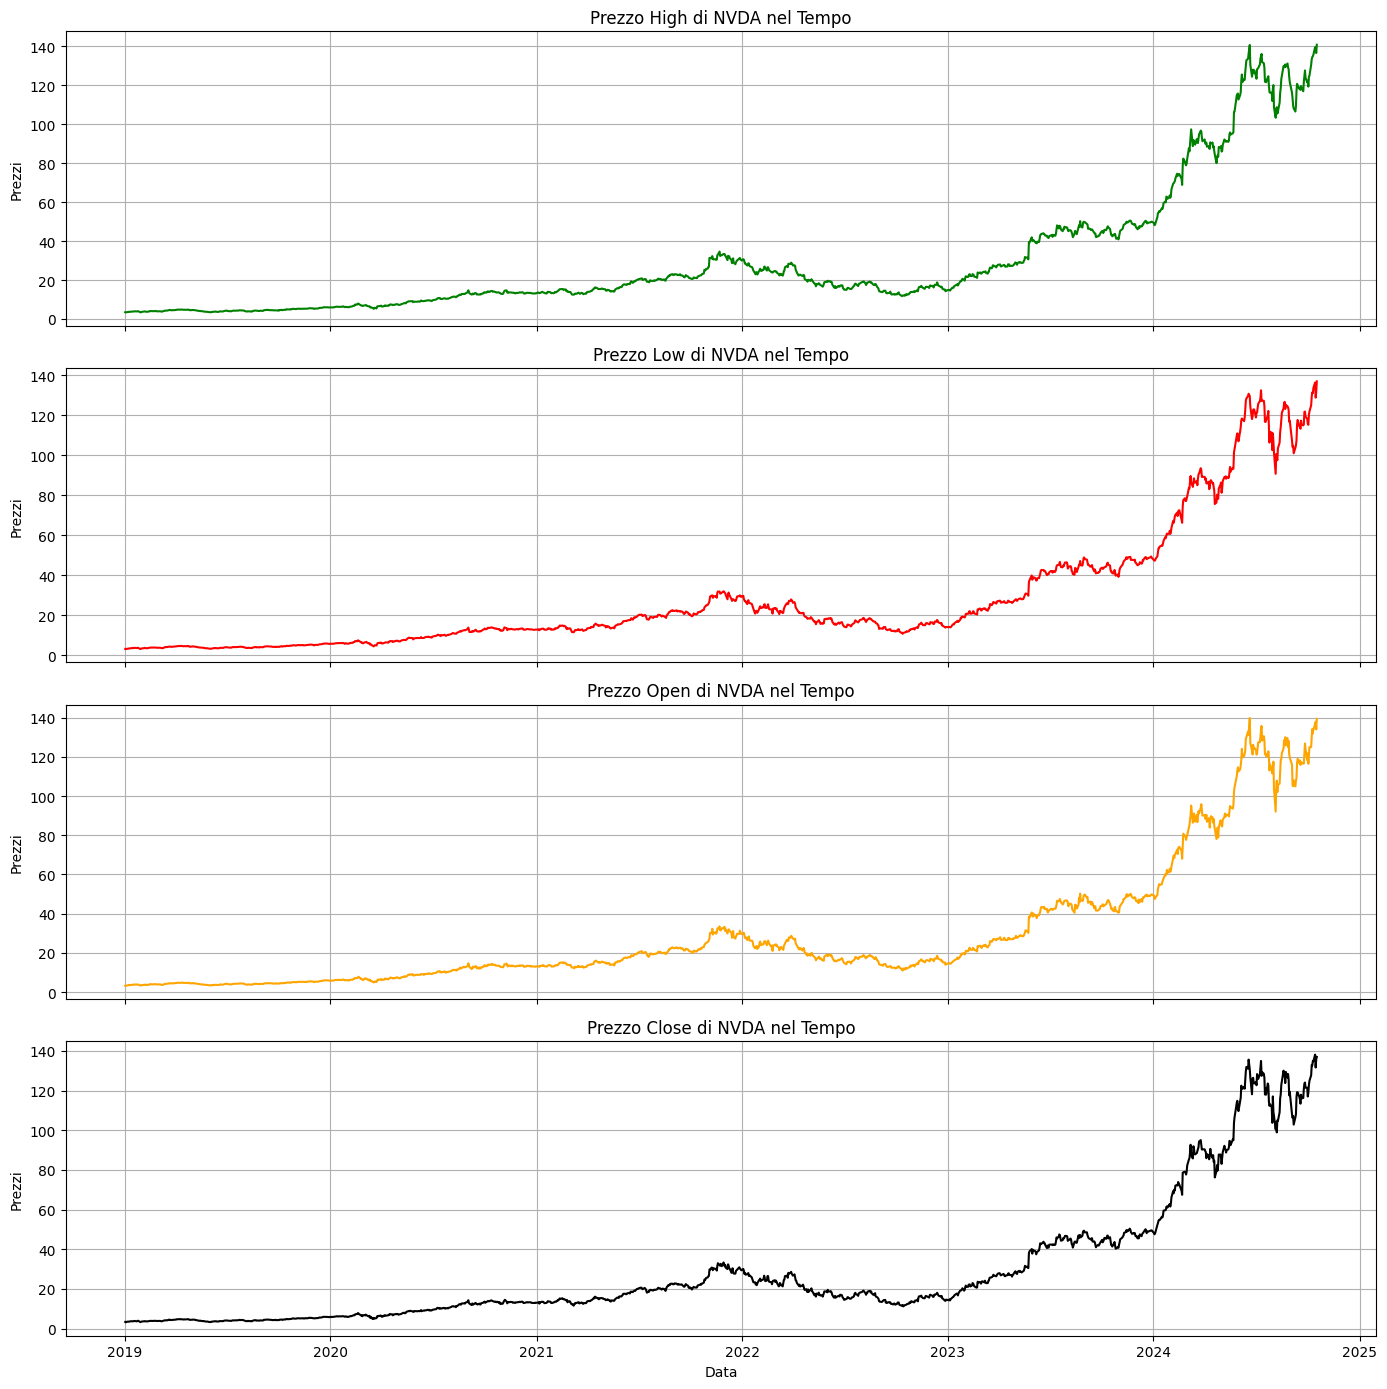

In [6]:
import matplotlib.pyplot as plt

# Creazione della figura con 4 sottografici
fig, axs = plt.subplots(4, 1, figsize=(14, 14), sharex=True)

# Grafico dei prezzi High
axs[0].plot(nvda_data['Date'], nvda_data['High'], color='green')
axs[0].set_title('Prezzo High di NVDA nel Tempo')
axs[0].set_ylabel('Prezzi')
axs[0].grid(True)

# Grafico dei prezzi Low
axs[1].plot(nvda_data['Date'], nvda_data['Low'], color='red')
axs[1].set_title('Prezzo Low di NVDA nel Tempo')
axs[1].set_ylabel('Prezzi')
axs[1].grid(True)

# Grafico dei prezzi Open
axs[2].plot(nvda_data['Date'], nvda_data['Open'], color='orange')
axs[2].set_title('Prezzo Open di NVDA nel Tempo')
axs[2].set_ylabel('Prezzi')
axs[2].grid(True)

# Grafico dei prezzi Close
axs[3].plot(nvda_data['Date'], nvda_data['Close'], color='black')
axs[3].set_title('Prezzo Close di NVDA nel Tempo')
axs[3].set_ylabel('Prezzi')
axs[3].set_xlabel('Data')
axs[3].grid(True)

# Aggiunta di spazi tra i sottografici
plt.tight_layout()

# Mostra la figura
plt.show()

Dato che tutte le variabili hanno media e varianza paragonabili e sono fortemente correlate tra loro, scegliamo come variabile da predire la differenza Close - Open

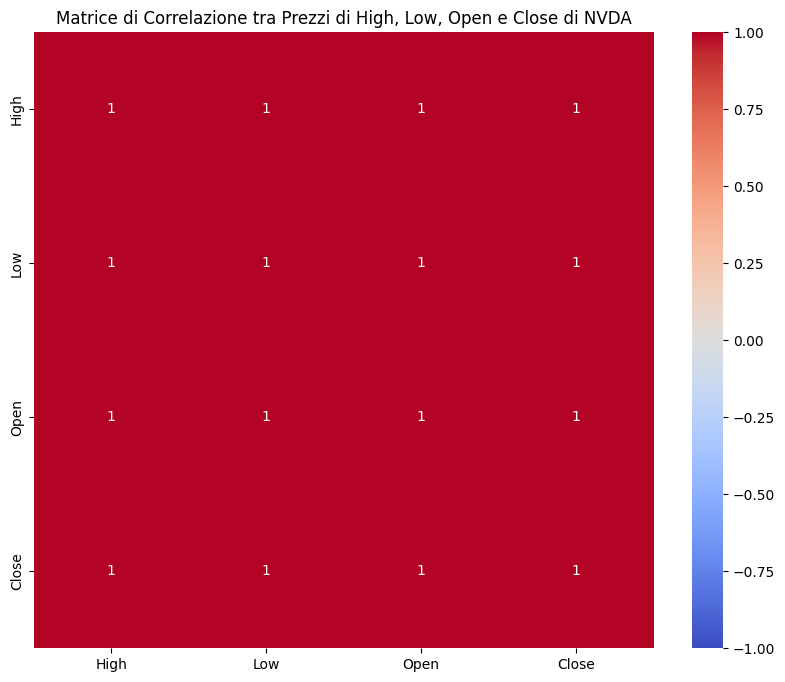

Statistiche descrittive per High, Low, Open e Close:

              High          Low         Open        Close
count  1478.000000  1478.000000  1478.000000  1478.000000
mean     31.046739    29.868270    30.478865    30.486058
std      34.702474    33.373683    34.090234    34.063212
min       3.379000     3.192250     3.266000     3.199750
25%       9.458750     9.129875     9.230875     9.235625
50%      17.515000    16.727501    17.015499    17.060000
75%      39.085999    37.175749    37.848499    37.744249
max     149.770004   146.259995   149.050003   148.880005


In [10]:
# Calcolare la correlazione tra le variabili
correlation_matrix = nvda_data[['High', 'Low', 'Open', 'Close']].corr()

# Visualizzare la matrice di correlazione
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Matrice di Correlazione tra Prezzi di High, Low, Open e Close di NVDA')
plt.show()

# Stampare statistiche descrittive per confrontare i valori
print("Statistiche descrittive per High, Low, Open e Close:\n")
print(nvda_data[['High', 'Low', 'Open', 'Close']].describe())

Visto che le grandezze analizzate sono molto correlate tra di loro con una simile media e std, ci concentriamo sul prezzo di apertura(open) e chiusura(close), cercando di prevedere la differenza open-close, per cosservare quanto è conveniente vendere in quel giorno.

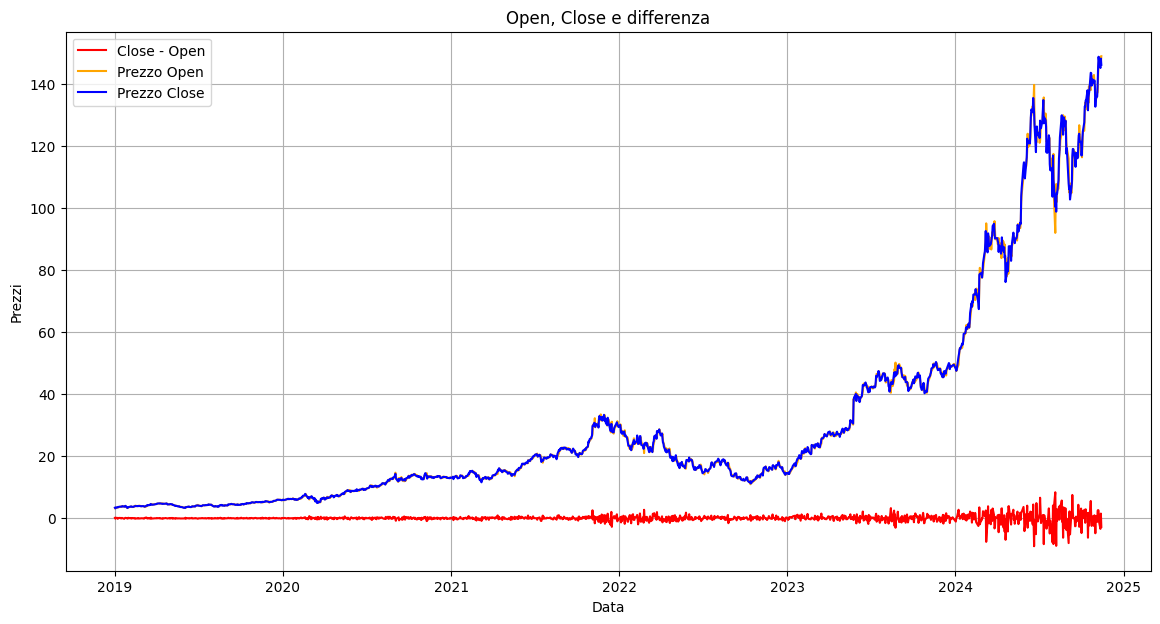

In [11]:
    # Tracciare il grafico dei prezzi di High, Low e Open
plt.figure(figsize=(14, 7))
plt.plot(nvda_data['Date'], nvda_data['Close']-nvda_data['Open'], label='Close - Open', color='red')
plt.plot(nvda_data['Date'], nvda_data['Open'], label='Prezzo Open', color='orange')
plt.plot(nvda_data['Date'], nvda_data['Close'], label='Prezzo Close', color='blue')
plt.title('Open, Close e differenza')
plt.xlabel('Data')
plt.ylabel('Prezzi')
plt.grid(True)
plt.legend()
plt.show()

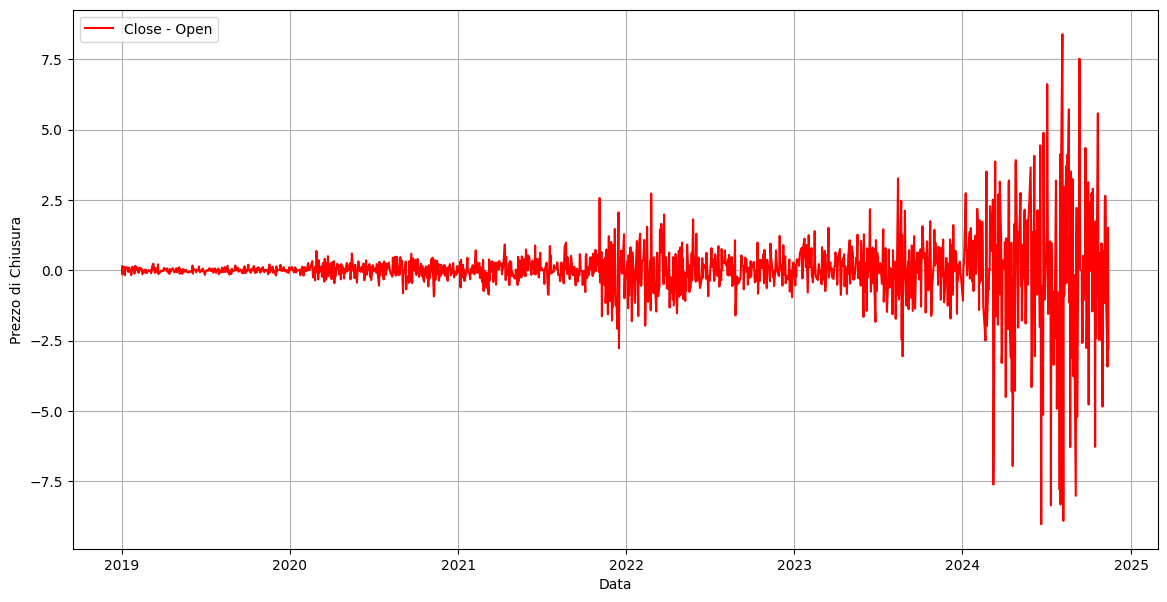

In [12]:
plt.figure(figsize=(14, 7))
plt.plot(nvda_data['Date'], nvda_data['Close']-nvda_data['Open'], label='Close - Open', color='red')
plt.xlabel('Data')
plt.ylabel('Prezzo di Chiusura')
plt.grid(True)
plt.legend()
plt.show()

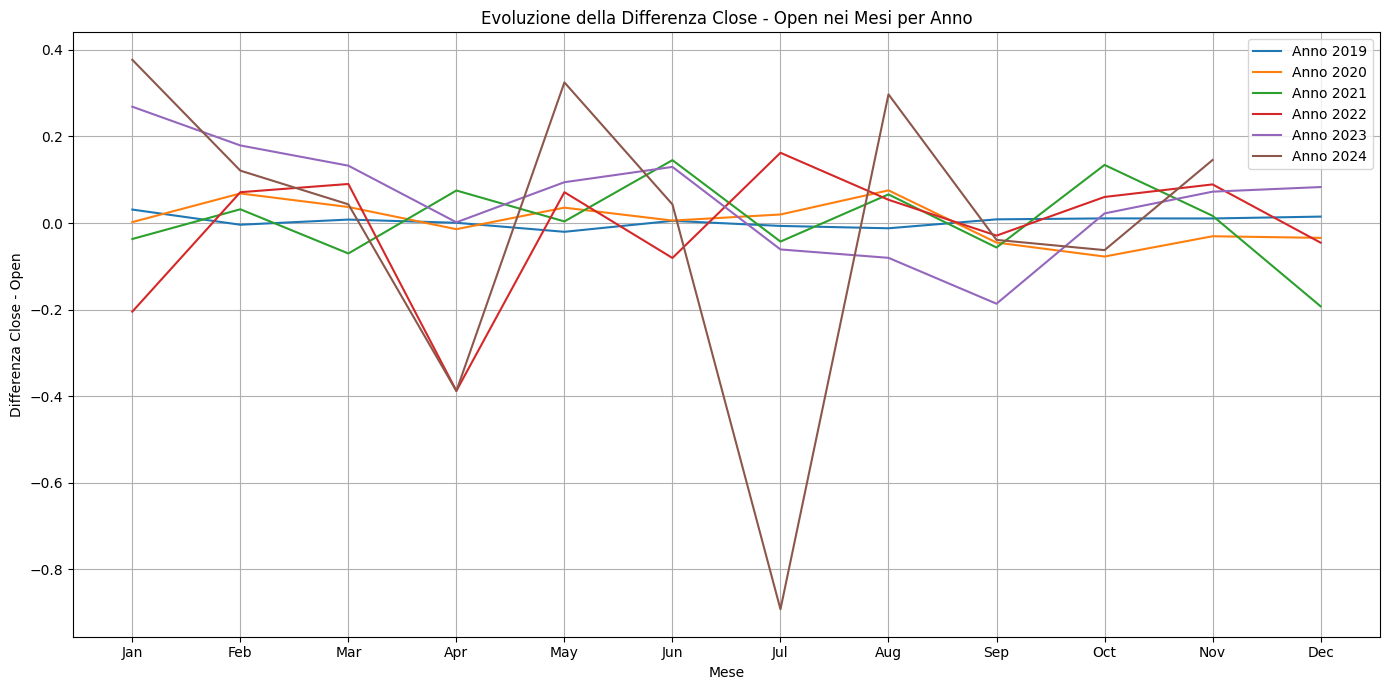

In [13]:
import matplotlib.pyplot as plt
import pandas as pd

# Assumiamo che 'nvda_data' sia già definito con le colonne 'Date', 'Close', 'Open'

# Assicurati che 'Date' sia nel formato datetime
nvda_data['Date'] = pd.to_datetime(nvda_data['Date'])

# Calcolare la differenza Close - Open
nvda_data['Close-Open'] = nvda_data['Close'] - nvda_data['Open']

# Aggiungere colonne per anno e mese
nvda_data['Year'] = nvda_data['Date'].dt.year
nvda_data['Month'] = nvda_data['Date'].dt.month

month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

# Creare il grafico
plt.figure(figsize=(14, 7))

# Per ogni anno, traccia la differenza Close-Open per i mesi
for year in nvda_data['Year'].unique():
    monthly_diff = nvda_data[nvda_data['Year'] == year].groupby('Month')['Close-Open'].mean()
    plt.plot(monthly_diff.index, monthly_diff.values, label=f'Anno {year}')

plt.xlabel('Mese')
plt.ylabel('Differenza Close - Open')
plt.title('Evoluzione della Differenza Close - Open nei Mesi per Anno')
plt.grid(True)
plt.legend()
plt.xticks(range(1, 13), labels=month_names)  # Aggiungi i numeri dei mesi (1-12)
plt.tight_layout()
plt.show()


## Decomposizione STL e decomposizione in train e test

Per la decomposizione in train e test:
-   test_data : 85 campioni.
-   train_data : 1393 campioni.

Nel train_data, abbiamo lasciato anche i campioni di anni precedenti al "boom" di vendite e guadagni di nvidia(anni pre 2020/2021), questo tende a far abbassare media e varianza verso lo 0, ciò nonostante abbiamo ritenuto corretto e necessario valutare sia gli anni prima del boom che quelli successivi.

In [14]:
# Ordina il DataFrame per la colonna Date
nvda_data = nvda_data.sort_values(by='Date')

# Trova la data di cutoff per gli ultimi 21 giorni
cutoff_date = nvda_data['Date'].max() - pd.Timedelta(days=120)

# Crea il DataFrame train e test
train_data = nvda_data[nvda_data['Date'] <= cutoff_date]
test_data = nvda_data[nvda_data['Date'] > cutoff_date]


print(f"Lughezza test: {len(test_data)}")
print(f"Lughezza train: {len(train_data)}")
print(f"Lunghezza totale: {len(nvda_data)}")


Lughezza test: 85
Lughezza train: 1393
Lunghezza totale: 1478


Nello split effettuato, è evidente che nel train_data la media è un ordine di grandezza più piccolo rispetto alla media di test_data, mentre la varianza di train_data è circa 9 volte più piccola rispetto alla varianza di test_data.

In [15]:
train_data['Close-Open'].describe()

count    1393.000000
mean        0.016598
std         0.912369
min        -9.020004
25%        -0.189250
50%         0.009250
75%         0.264000
max         6.619995
Name: Close-Open, dtype: float64

In [17]:
import copy


train_data['Difference'] = train_data['Close'] - train_data['Open']
train_data.head()


nvda_data_copy = copy.deepcopy(train_data)
# Verifica che la colonna 'data' sia in formato datetime
nvda_data_copy['Date'] = pd.to_datetime(nvda_data['Date'])

# Imposta la colonna 'data' come indice del DataFrame
nvda_data_copy.set_index('Date', inplace=True)

C:\Users\lucab\AppData\Local\Temp\ipykernel_18476\4286710890.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['Difference'] = train_data['Close'] - train_data['Open']


Data la volubilità della serie e le diverse variabili(endogene ed esogene) in gioco, per la scomposizione STL abbiamo tenuto conto di un periodo di 1 settimana lavorativa(5 giorni).

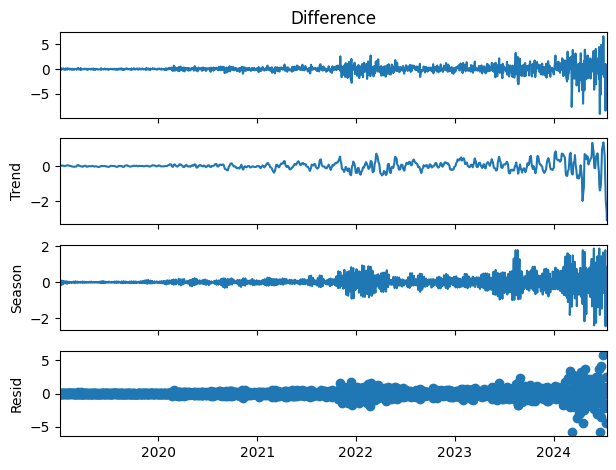

In [18]:
# Esegui la decomposizione STL
stl = STL(nvda_data_copy['Difference'], period=5)  # Modifica la stagionalità a seconda dei tuoi dati
result = stl.fit()

res = stl.fit()
fig = res.plot()



## Stationarity

In [19]:
def test_stationarity(ts):
    stats = ['Test Statistic','p-value']
    df_test = adfuller(ts)
    df_results = pd.Series(df_test[0:2], index=stats)
    
    print('ADF statistic:', df_results.iloc[0])
    print('P-value:', df_results.iloc[1])

In [20]:
test_stationarity(train_data['Difference'])

ADF statistic: -7.941096160289918
P-value: 3.3123334220603126e-12


## ACF and PACF graph

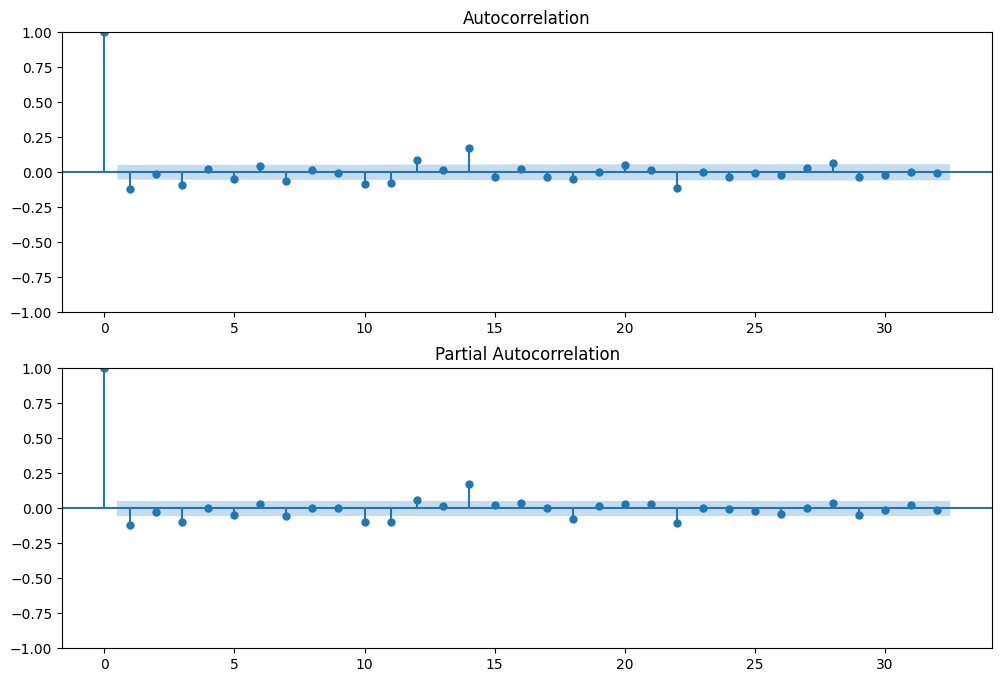

In [34]:
# ACF, PACF graphs to help determine order of ARIMA model, again statsmodel has these handy functions built-in
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(train_data['Difference'],  ax=ax1)   # first value of diff is NaN
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(train_data['Difference'], ax=ax2)

# Fitting model

## Arima

In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pmdarima import auto_arima

# Trova automaticamente il miglior modello SARIMA con auto_arima
model = auto_arima(train_data['Difference'], seasonal=False, stepwise=True, trace=True)

# Stampa i parametri del miglior modello trovato
print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=3661.922, Time=0.65 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=3699.117, Time=0.04 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=3680.524, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=3679.040, Time=0.05 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=3673.948, Time=0.35 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=3673.784, Time=0.17 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=3663.267, Time=0.40 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=3663.240, Time=0.48 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=3672.929, Time=0.13 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=3665.440, Time=0.33 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=3667.570, Time=0.46 sec
 ARIMA(3,0,3)(0,0,0)[0]             : AIC=3665.151, Time=1.49 sec
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=3662.826, Time=1.19 sec

Best model:  ARIMA(2,0,2)(0,0,0)[0]          
Total fit time: 5.767 seconds
                      

In [70]:
model = ARIMA(train_data['Difference'], order=(2,0,2))
results = model.fit()

print(results.summary())

c:\Users\lucab\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\lucab\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\lucab\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:             Difference   No. Observations:                 1393
Model:                 ARIMA(2, 0, 2)   Log Likelihood               -1825.413
Date:                Sun, 17 Nov 2024   AIC                           3662.826
Time:                        20:28:39   BIC                           3694.261
Sample:                             0   HQIC                          3674.580
                               - 1393                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0176      0.018      1.001      0.317      -0.017       0.052
ar.L1         -0.2755      0.054     -5.101      0.000      -0.381      -0.170
ar.L2          0.6398      0.046     13.890      0.0

Il modello ARIMA(2,0,2) seppur il migliore, a detta di auto_arima, non può essere un modello valido per via del 4 grafico: nel lag 9 qualcosa non viene correttamente modellato. 

Ulteriori modelli portano ad una complicazione a livello di numero di parametri e interpretabilità, non portando comunque buoni risultati.

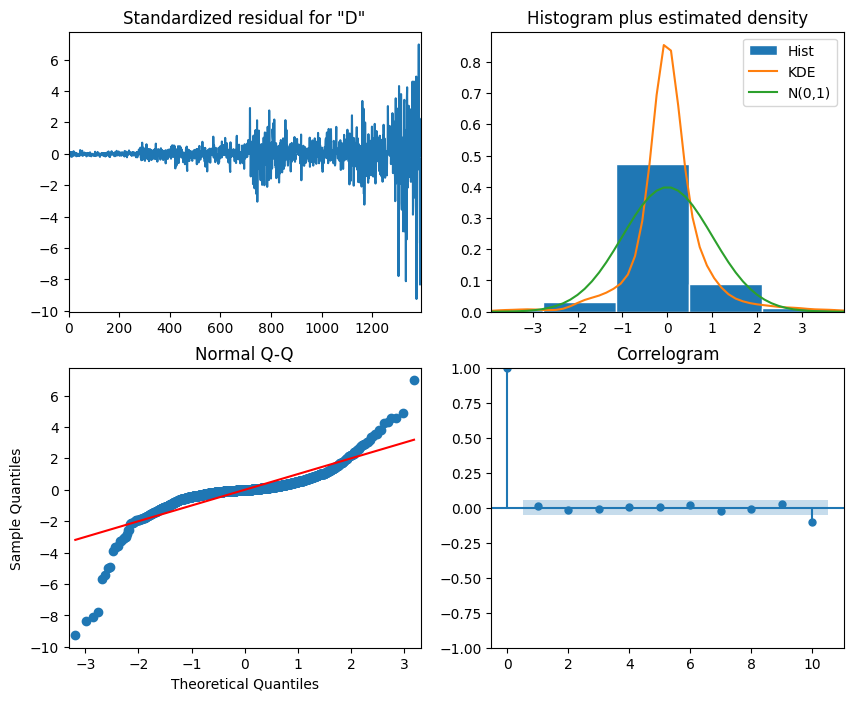

In [71]:
results.plot_diagnostics(figsize=(10, 8))
plt.show()

In [76]:
# Test di Ljung-Box sui residui
lb_test = acorr_ljungbox(results.resid, lags=[10, 20, 30], return_df=True)
print("Risultati del test di Ljung-Box:")
print(lb_test)


Risultati del test di Ljung-Box:
       lb_stat     lb_pvalue
10   17.083779  7.253059e-02
20   77.922524  8.817412e-09
30  110.399574  3.957635e-11


All'aumentare delle previsioni, i risultati si schicciano sulla media. Siccome sia il training che il test data hanno media (quasi)nulla, allora la previsione per valori temporali molto grandi si "schiaccia" su zero

c:\Users\lucab\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\lucab\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


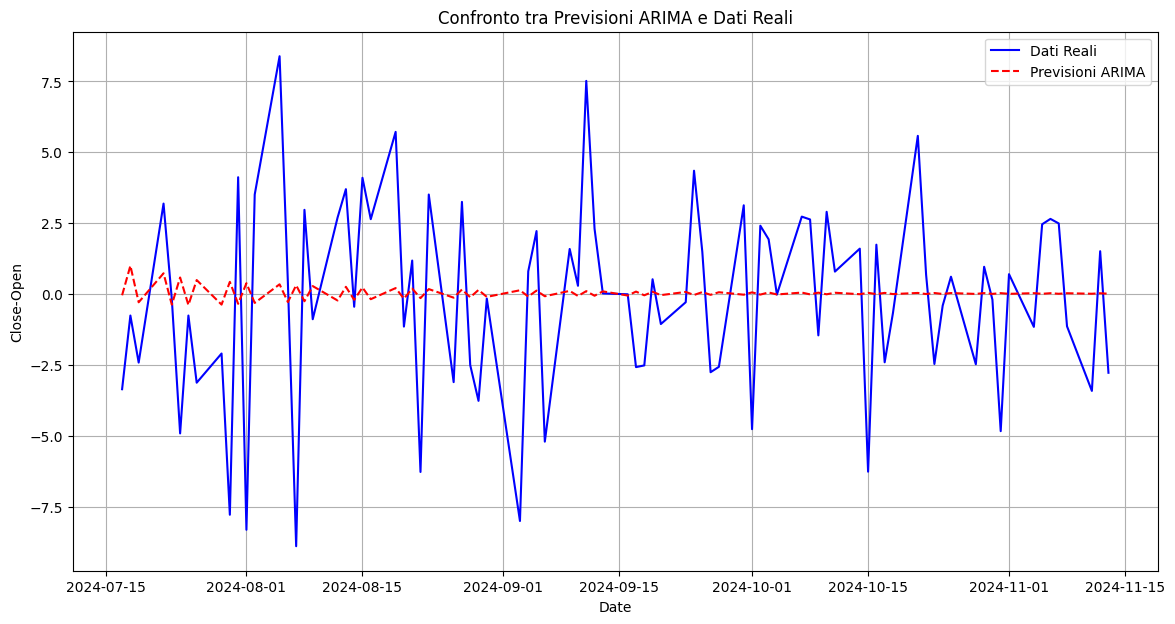

In [73]:
import pandas as pd
import matplotlib.pyplot as plt

# Assumendo che il tuo modello SARIMAX sia già stato allenato e salvato in `results_base`
# e che `test_data` sia un DataFrame contenente le colonne descritte.

# Definire le variabili esogene e la variabile target

y_true = test_data['Close-Open']

# Fare la previsione con il modello SARIMAX
predictions = results.get_forecast(steps=len(test_data))
y_pred = predictions.predicted_mean

# Impostare l'indice temporale per il grafico
y_true.index = test_data['Date']
y_pred.index = test_data['Date']

# Creare il grafico
plt.figure(figsize=(14, 7))
plt.plot(y_true, label='Dati Reali', color='blue')
plt.plot(y_pred, label='Previsioni ARIMA', color='red', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Close-Open')
plt.title('Confronto tra Previsioni ARIMA e Dati Reali')
plt.legend()
plt.grid(True)
plt.show()


c:\Users\lucab\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\lucab\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


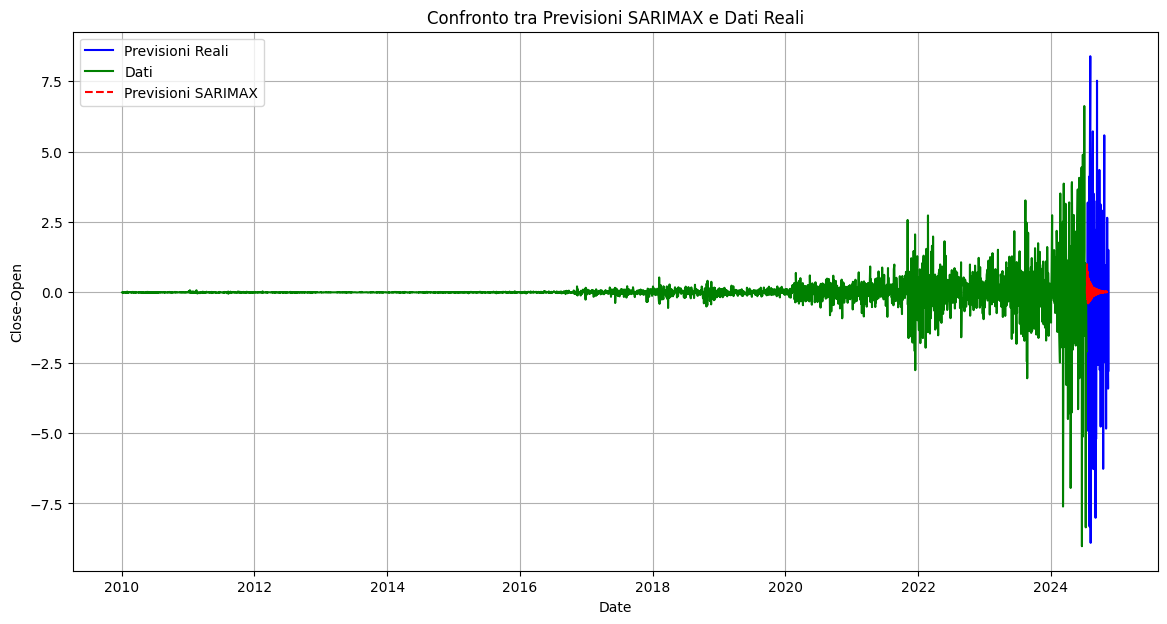

In [78]:
import pandas as pd
import matplotlib.pyplot as plt

# Assumendo che il tuo modello SARIMAX sia già stato allenato e salvato in `results_base`
# e che `test_data` sia un DataFrame contenente le colonne descritte.

# Definire le variabili esogene e la variabile target
exog_test = test_data[['Volume']]
y_true = test_data['Close-Open']

# Fare la previsione con il modello SARIMAX
predictions = results.get_forecast(steps=len(test_data))
y_pred = predictions.predicted_mean



result_df = nvda_data[~nvda_data['Date'].isin(test_data['Date'])]


# Impostare l'indice temporale per il grafico
y_true.index = test_data['Date']
y_pred.index = test_data['Date']
result_df.index = result_df['Date']
# Creare il grafico
plt.figure(figsize=(14, 7))
plt.plot(y_true, label='Previsioni Reali', color='blue')
plt.plot(result_df['Close']-result_df['Open'], label='Dati', color='green')
plt.plot(y_pred, label='Previsioni SARIMAX', color='red', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Close-Open')
plt.title('Confronto tra Previsioni SARIMAX e Dati Reali')
plt.legend()
plt.grid(True)
plt.show()


c:\Users\lucab\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\lucab\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


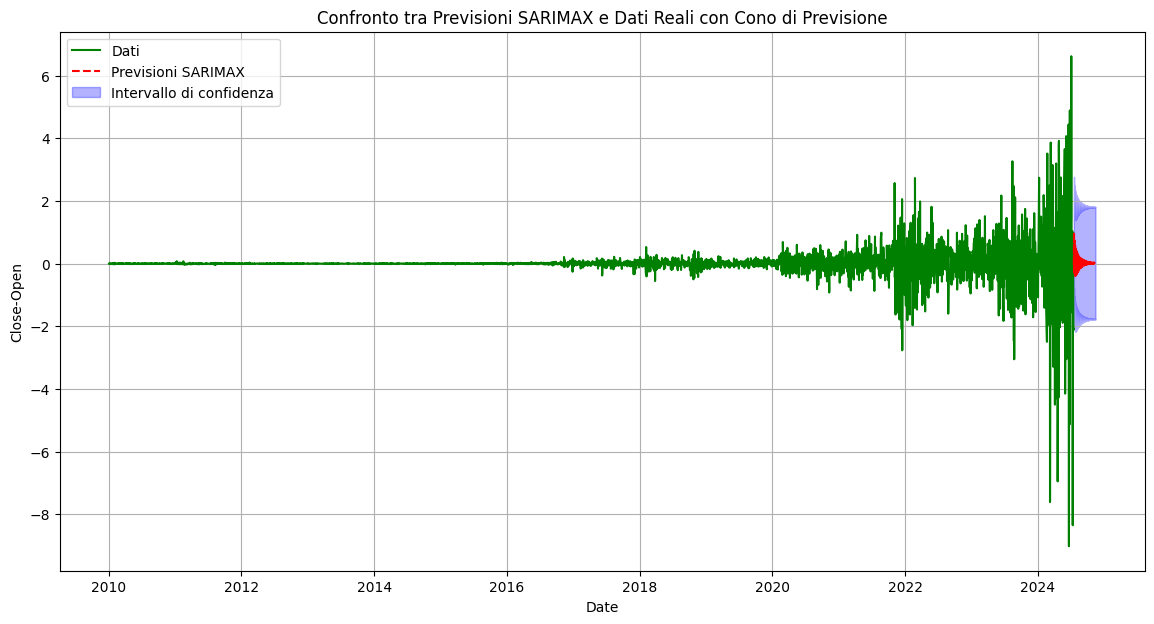

In [81]:
import pandas as pd
import matplotlib.pyplot as plt

# Assumendo che il tuo modello SARIMAX sia già stato allenato e salvato in `results_base`
# e che `test_data` sia un DataFrame contenente le colonne descritte.

# Definire le variabili esogene e la variabile target

y_true = test_data['Close-Open']

# Fare la previsione con il modello SARIMAX
predictions = results.get_forecast(steps=len(test_data))
y_pred = predictions.predicted_mean

# Ottenere gli intervalli di confidenza
conf_int = predictions.conf_int()

# Impostare l'indice temporale per il grafico
y_true.index = test_data['Date']
y_pred.index = test_data['Date']
conf_int.index = test_data['Date']
result_df.index = result_df['Date']

# Creare il grafico
plt.figure(figsize=(14, 7))
#plt.plot(y_true, label='Previsioni Reali', color='blue')
plt.plot(result_df['Close'] - result_df['Open'], label='Dati', color='green')
plt.plot(y_pred, label='Previsioni SARIMAX', color='red', linestyle='--')

# Aggiungere il cono di previsione
plt.fill_between(conf_int.index, 
                 conf_int.iloc[:, 0],  # Limite inferiore
                 conf_int.iloc[:, 1],  # Limite superiore
                 color='blue', alpha=0.3, label='Intervallo di confidenza')

plt.xlabel('Date')
plt.ylabel('Close-Open')
plt.title('Confronto tra Previsioni SARIMAX e Dati Reali con Cono di Previsione')
plt.legend()
plt.grid(True)
plt.show()


In [39]:
# Calcolare gli indicatori di valutazione
mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
mape = mean_absolute_percentage_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

# Stampare gli indicatori di valutazione
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.4f}")
print(f"R²: {r2:.4f}")

Mean Absolute Error (MAE): 2.7005
Mean Squared Error (MSE): 11.9856
Root Mean Squared Error (RMSE): 3.4620
Mean Absolute Percentage Error (MAPE): 1.0673
R²: -0.0193


## Sarimax

Modello SARIMAX(2,0,2)(2,0,2,5) con variabili esogene: volume.

Per la componente stagionale, abbiamo scelto un periodo di 5 

In [40]:
# Modello SARIMA
exog_vars = train_data[['Volume']]
model = sm.tsa.SARIMAX(train_data['Difference'],
                       order=(2,0,2),           # Parametri ARIMA
                       seasonal_order=(2,0,2,5), # Parametri stagionali (P, D, Q, periodo stagionale S),
                       exog=exog_vars,
                       trend='t')                  # Se includere o meno l'intercetta (opzionale)

results_base = model.fit()

# Sommario del modello
print(results_base.summary())

c:\Users\lucab\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\lucab\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


                                     SARIMAX Results                                     
Dep. Variable:                        Difference   No. Observations:                 1393
Model:             SARIMAX(2, 0, 2)x(2, 0, 2, 5)   Log Likelihood               -1822.194
Date:                           Sun, 17 Nov 2024   AIC                           3666.387
Time:                                   19:37:22   BIC                           3724.018
Sample:                                        0   HQIC                          3687.936
                                          - 1393                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
drift       3.371e-05   2.94e-05      1.145      0.252    -2.4e-05    9.14e-05
Volume      8.953e-12    7.3e-11      0.123

c:\Users\lucab\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


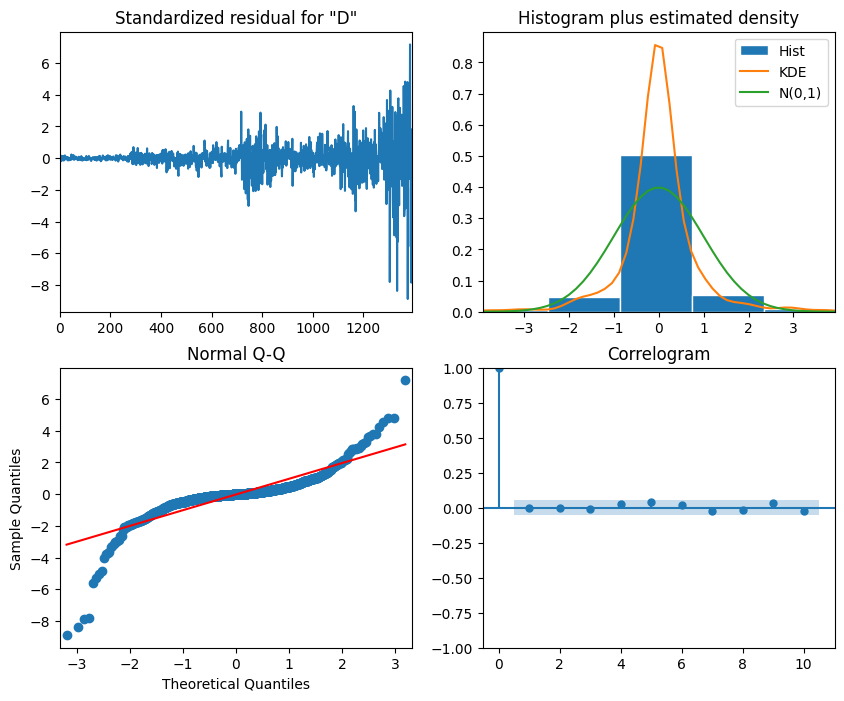

In [41]:
results_base.plot_diagnostics(figsize=(10, 8))
plt.show()

In [42]:
# Test di Ljung-Box sui residui
lb_test = acorr_ljungbox(results_base.resid, lags=[10, 20, 30], return_df=True)
print("Risultati del test di Ljung-Box:")
print(lb_test)


Risultati del test di Ljung-Box:
      lb_stat     lb_pvalue
10   7.695843  6.585188e-01
20  61.592220  4.026686e-06
30  93.727485  1.768444e-08


I graifici successivi mostrano la predizione e i dati "reali". Anche se può sembrare che il nostro modello predica male, come dimostra il grafico è i vari indicatori(MAPE,...) in realtà non è proprio così.

Il modello è stato addestrato con dati di training a bassa varianza(circa 0.8), mentre i dati di test hanno una varianza molto elevata(circa 8/9). I valori predetti, hanno una varianza di circa 0.6, simile ai dati di addestramento ma molto distanti dai dati di test. 

La bassa varianza dei dati di training è dovuta dal fatto che consideriamo anche valori di anni pre-covid dove Nvidia non ha registrato grosse vendite e quindi grossi volumi e prezzi di entrata/uscita, questo tende a far avere dei valori Close-Open molto vicini allo zero.

c:\Users\lucab\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\lucab\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


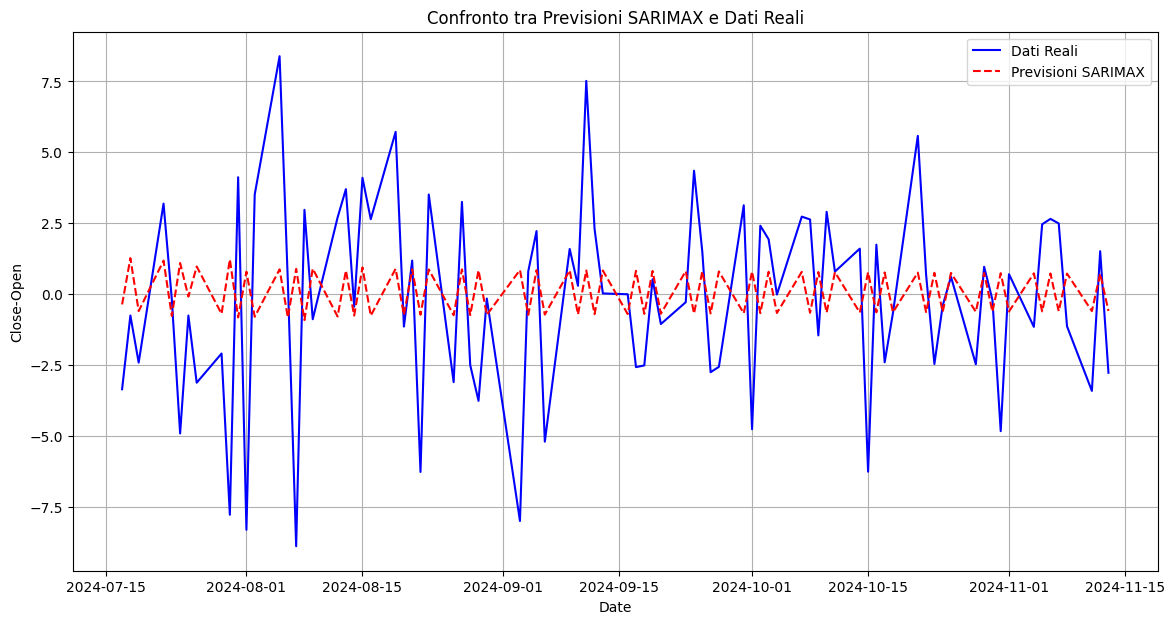

In [43]:
import pandas as pd
import matplotlib.pyplot as plt

# Assumendo che il tuo modello SARIMAX sia già stato allenato e salvato in `results_base`
# e che `test_data` sia un DataFrame contenente le colonne descritte.

# Definire le variabili esogene e la variabile target
exog_test = test_data[['Volume']]
y_true = test_data['Close-Open']

# Fare la previsione con il modello SARIMAX
predictions = results_base.get_forecast(steps=len(test_data), exog=exog_test)
y_pred = predictions.predicted_mean

# Impostare l'indice temporale per il grafico
y_true.index = test_data['Date']
y_pred.index = test_data['Date']

# Creare il grafico
plt.figure(figsize=(14, 7))
plt.plot(y_true, label='Dati Reali', color='blue')
plt.plot(y_pred, label='Previsioni SARIMAX', color='red', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Close-Open')
plt.title('Confronto tra Previsioni SARIMAX e Dati Reali')
plt.legend()
plt.grid(True)
plt.show()


c:\Users\lucab\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\lucab\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


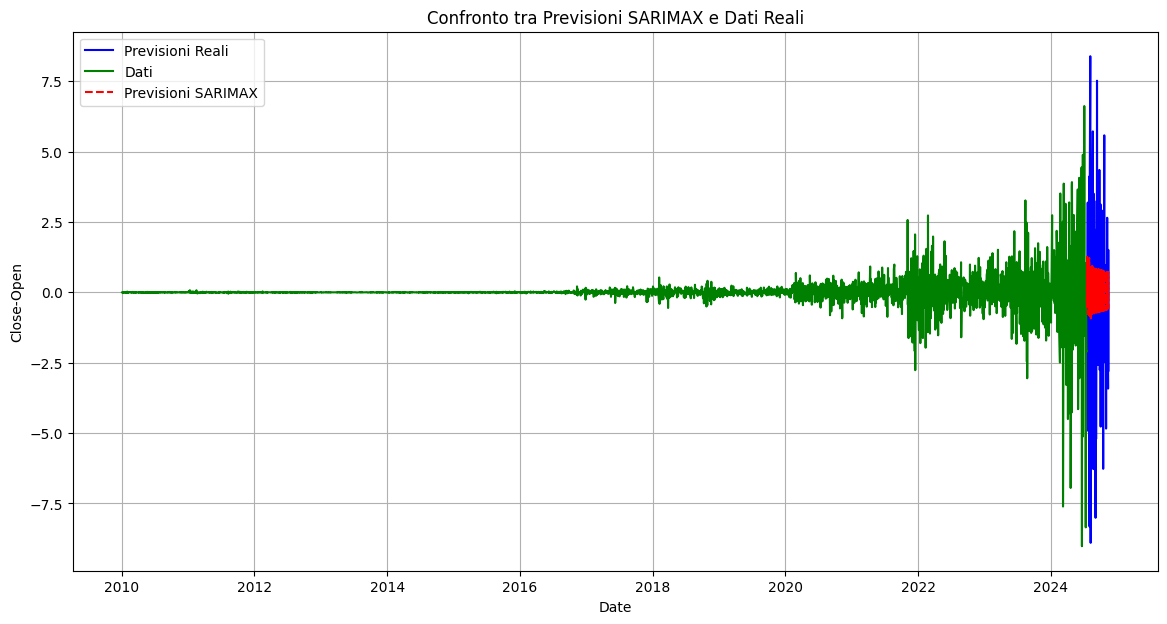

In [66]:
import pandas as pd
import matplotlib.pyplot as plt

# Assumendo che il tuo modello SARIMAX sia già stato allenato e salvato in `results_base`
# e che `test_data` sia un DataFrame contenente le colonne descritte.

# Definire le variabili esogene e la variabile target
exog_test = test_data[['Volume']]
y_true = test_data['Close-Open']

# Fare la previsione con il modello SARIMAX
predictions = results_base.get_forecast(steps=len(test_data), exog=exog_test)
y_pred = predictions.predicted_mean



result_df = nvda_data[~nvda_data['Date'].isin(test_data['Date'])]


# Impostare l'indice temporale per il grafico
y_true.index = test_data['Date']
y_pred.index = test_data['Date']
result_df.index = result_df['Date']
# Creare il grafico
plt.figure(figsize=(14, 7))
plt.plot(y_true, label='Previsioni Reali', color='blue')
plt.plot(result_df['Close']-result_df['Open'], label='Dati', color='green')
plt.plot(y_pred, label='Previsioni SARIMAX', color='red', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Close-Open')
plt.title('Confronto tra Previsioni SARIMAX e Dati Reali')
plt.legend()
plt.grid(True)
plt.show()


c:\Users\lucab\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\lucab\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


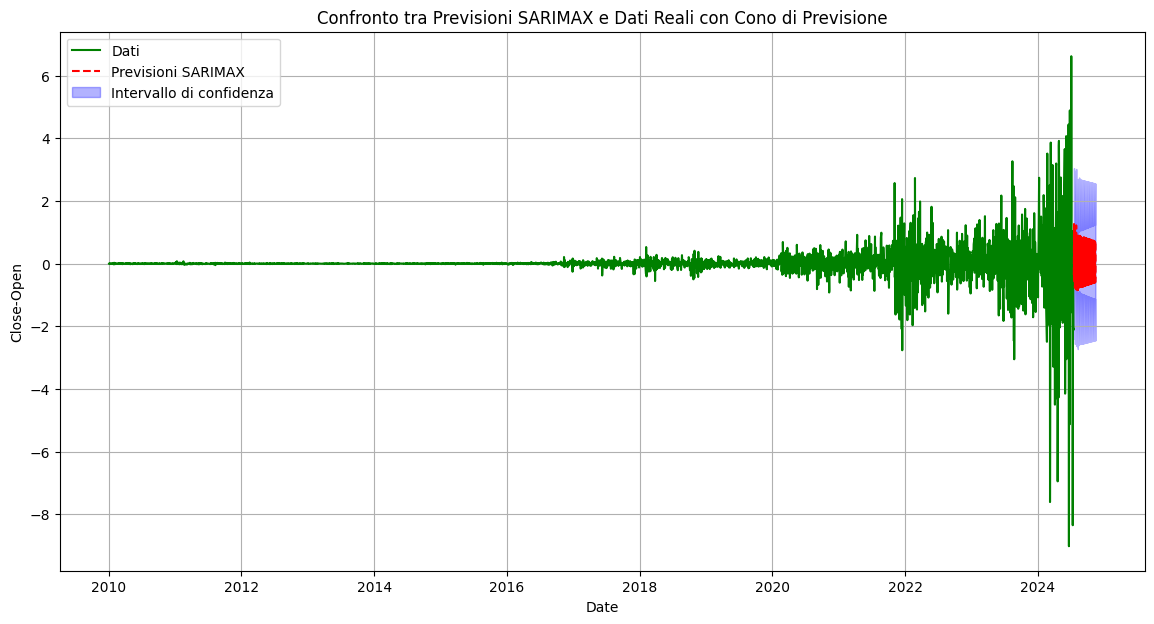

In [69]:
import pandas as pd
import matplotlib.pyplot as plt

# Assumendo che il tuo modello SARIMAX sia già stato allenato e salvato in `results_base`
# e che `test_data` sia un DataFrame contenente le colonne descritte.

# Definire le variabili esogene e la variabile target
exog_test = test_data[['Volume']]
y_true = test_data['Close-Open']

# Fare la previsione con il modello SARIMAX
predictions = results_base.get_forecast(steps=len(test_data), exog=exog_test)
y_pred = predictions.predicted_mean

# Ottenere gli intervalli di confidenza
conf_int = predictions.conf_int()

# Impostare l'indice temporale per il grafico
y_true.index = test_data['Date']
y_pred.index = test_data['Date']
conf_int.index = test_data['Date']
result_df.index = result_df['Date']

# Creare il grafico
plt.figure(figsize=(14, 7))
#plt.plot(y_true, label='Previsioni Reali', color='blue')
plt.plot(result_df['Close'] - result_df['Open'], label='Dati', color='green')
plt.plot(y_pred, label='Previsioni SARIMAX', color='red', linestyle='--')

# Aggiungere il cono di previsione
plt.fill_between(conf_int.index, 
                 conf_int.iloc[:, 0],  # Limite inferiore
                 conf_int.iloc[:, 1],  # Limite superiore
                 color='blue', alpha=0.3, label='Intervallo di confidenza')

plt.xlabel('Date')
plt.ylabel('Close-Open')
plt.title('Confronto tra Previsioni SARIMAX e Dati Reali con Cono di Previsione')
plt.legend()
plt.grid(True)
plt.show()


In [44]:
y_pred.describe()

count    85.000000
mean      0.074479
std       0.777230
min      -0.921472
25%      -0.691285
50%      -0.091969
75%       0.813112
max       1.265086
Name: predicted_mean, dtype: float64

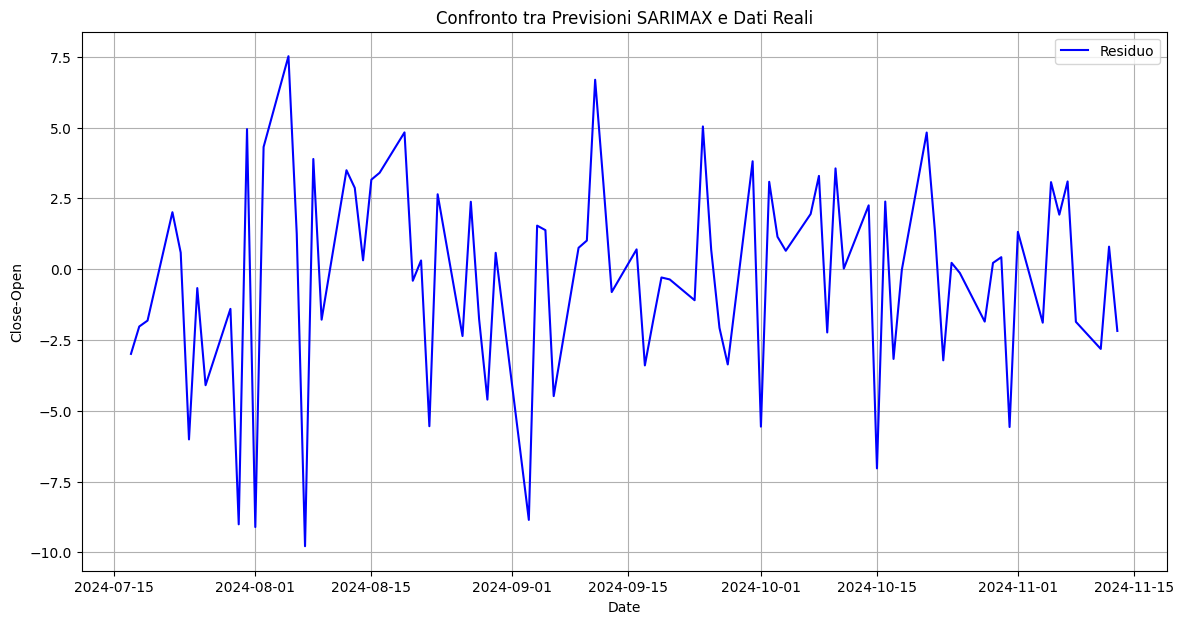

count    85.000000
mean     -0.221419
std       3.589572
min      -9.785340
25%      -2.073889
50%       0.307644
75%       2.381026
max       7.520945
dtype: float64

In [45]:
# Creare il grafico
plt.figure(figsize=(14, 7))
plt.plot(y_true-y_pred, label='Residuo', color='blue')
plt.xlabel('Date')
plt.ylabel('Close-Open')
plt.title('Confronto tra Previsioni SARIMAX e Dati Reali')
plt.legend()
plt.grid(True)
plt.show()


(y_true-y_pred).describe()

In [46]:
# Calcolare gli indicatori di valutazione
mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
mape = mean_absolute_percentage_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

# Stampare gli indicatori di valutazione
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.4f}")
print(f"R²: {r2:.4f}")

Mean Absolute Error (MAE): 2.7788
Mean Squared Error (MSE): 12.7825
Root Mean Squared Error (RMSE): 3.5753
Mean Absolute Percentage Error (MAPE): 2.7976
R²: -0.0871
